In [53]:
    
from mesa.space import MultiGrid
from mesa import Model
from mesa.time import RandomActivation
import numpy as np
from queue import Queue


class ElFarolBar(Model):
    def __init__(self, crowdthreshold=60,num_strategies=10,memory_size = 10,width = 100,height = 100,N=100):
        self.running = True 
        self.num_agents = N
        self.schedule = RandomActivation(self)
        self.grid = MultiGrid(width, height, True)
        self.history = np.random.randint(0,100,size = memory_size*2).tolist()
        self.attendance = self.history[0]
        for i in range(self.num_agents):
            a = BarCustomer(i,self, num_strategies,memory_size,crowdthreshold) 
            self.schedule.add(a)
        self.datacollector = DataCollector(
            model_reporters ={'Customers':"attendance"})
            #agent_reporters={"Bar": "Bar"})
    def step(self):
        self.datacollector.collect(self)
        self.attendance = 0
        self.schedule.step()
        self.history.pop(0)
        self.history.append(self.attendance)
        for agent in self.schedule.agent_buffer(shuffled=False):
            agent.update_strategies()
        


In [59]:
from mesa import Agent
from mesa.datacollection import DataCollector

class BarCustomer(Agent):
    def __init__(self, unique_id, model,num_strategies,memory_size,crowdthreshold):
        super().__init__(unique_id, model)
        self.strategies = 1- np.random.rand(num_strategies,memory_size+1)*2
        self.best_strategy = self.strategies[0]
        self.attend = False
        self.memory_size = memory_size
        self.crowdthreshold = crowdthreshold
        self.update_strategies()

    #need to add step method here, to activate make_decision
    def step(self):
        prediction = self.predict_attendance(self.best_strategy,self.model.history[-self.memory_size:])
        if prediction<=self.crowdthreshold:
            self.attend = True
            self.model.attendance = self.model.attendance +1
        else: 
            self.attend = False
    
    def update_strategies(self):
        best_score = float('inf')
        for strategy in self.strategies:
            score, week = 0,0
            for _ in range(self.memory_size):
                prediction = self.predict_attendance(strategy,\
                                                     self.model.history[week:week+self.memory_size])
                socre = score + abs(self.model.history[week+self.memory_size]-prediction)
                week = week + 1
            if score <= best_score:
                best_score = score
                self.best_strategy = strategy
    
    def predict_attendance(self,strategy,subhistory):
        #print(strategy[1:],subhistory,strategy[0],strategy[0]*100+ sum(strategy[1:]*subhistory))
        return strategy[0]*100+ sum(strategy[1:]*subhistory)

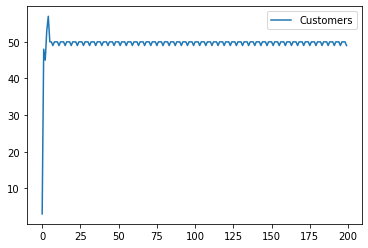

In [95]:
model = ElFarolBar(N=100,crowdthreshold=50,memory_size=5)
for i in range(200):
    model.step()
gini = model.datacollector.get_model_vars_dataframe()
gini.plot()

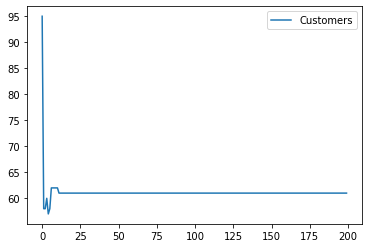

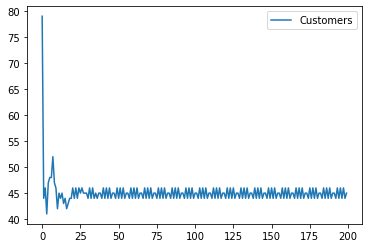

In [96]:
model = ElFarolBar(N=100,crowdthreshold=60,memory_size=5)
for i in range(200):
    model.step()
gini = model.datacollector.get_model_vars_dataframe()
gini.plot()

model = ElFarolBar(N=100,crowdthreshold=60,memory_size=10)
for i in range(200):
    model.step()
gini = model.datacollector.get_model_vars_dataframe()
gini.plot()

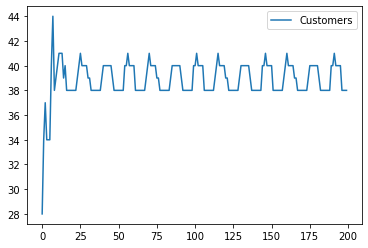

In [97]:
model = ElFarolBar(N=100,crowdthreshold=60,memory_size=10)
for i in range(200):
    model.step()
gini = model.datacollector.get_model_vars_dataframe()
gini.plot()

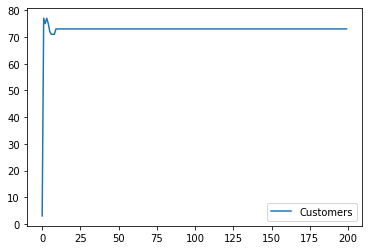

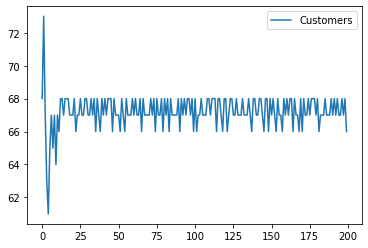

In [60]:
model = ElFarolBar(N=100,crowdthreshold=70,memory_size=5)
for i in range(200):
    model.step()
gini = model.datacollector.get_model_vars_dataframe()
gini.plot()

model = ElFarolBar(N=100,crowdthreshold=70,memory_size=10)#,num_strategies=20)
for i in range(200):
    model.step()
gini = model.datacollector.get_model_vars_dataframe()
gini.plot()

In [64]:
class ElFarolBarIBLT(Model):
    def __init__(self, crowdthreshold=60,decay=1,memory_size = 10,width = 100,height = 100,N=100):
        self.running = True 
        self.num_agents = N
        self.schedule = RandomActivation(self)
        self.grid = MultiGrid(width, height, True)
        self.history = np.random.randint(0,100,size = memory_size*2).tolist()
        self.attendance = self.history[0]
        for i in range(self.num_agents):
            a = BarCustomerIBLT(i,self,decay,crowdthreshold) 
            self.schedule.add(a)
        self.datacollector = DataCollector(
            model_reporters ={'Customers':"attendance"})
            #agent_reporters={"Bar": "Bar"})
    def step(self):
        self.datacollector.collect(self)
        self.attendance = 0
        self.schedule.step()
        self.history.pop(0)
        self.history.append(self.attendance)
        for agent in self.schedule.agent_buffer(shuffled=False):
            agent.update_strategies()

In [76]:
##Cognitive based model IBLT 
import pyibl 

class BarCustomerIBLT(Agent):
    def __init__(self, unique_id, model,decay,crowdthreshold):
        super().__init__(unique_id, model)
        self.agent = pyibl.Agent("BarCustomer",["Attendence"],decay = decay)
        self.agent.default_utility=10
        self.attend = False
        self.utility = 10
        self.crowdthreshold = crowdthreshold
        self.step()
        self.update_strategies()
        

    #need to add step method here, to activate make_decision
    def step(self):
        choise = self.agent.choose('Attend','Not Attend')
        if choise =='Attend':
            self.attend = True
            self.model.attendance = self.model.attendance +1
        else: 
            self.attend = False
    
    def update_strategies(self):
        if (self.model.history[-1]>self.crowdthreshold and self.attend ==True) or (self.model.history[-1]<self.crowdthreshold and self.attend ==False):
            self.agent.respond(-1)
        else:
            self.agent.respond(1)

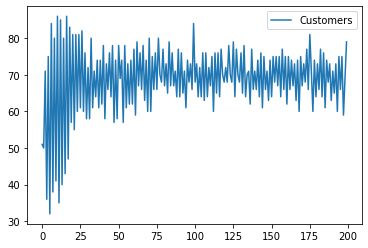

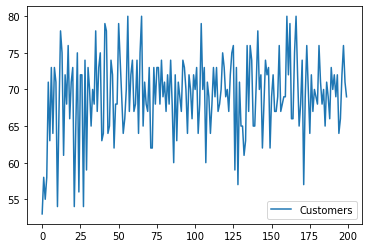

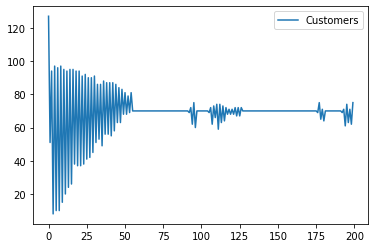

In [79]:
model = ElFarolBarIBLT(N=100,crowdthreshold=70,memory_size=5,decay = 1)
for i in range(200):
    model.step()
gini = model.datacollector.get_model_vars_dataframe()
gini.plot()

model = ElFarolBarIBLT(N=100,crowdthreshold=70,memory_size=5,decay = 0.1)

for i in range(200):
    model.step()
gini = model.datacollector.get_model_vars_dataframe()
gini.plot()
model = ElFarolBarIBLT(N=100,crowdthreshold=70,memory_size=5,decay = 2.5)

for i in range(200):
    model.step()
gini = model.datacollector.get_model_vars_dataframe()
gini.plot()

In [75]:
import pyibl 
a = pyibl.Agent("BarCustomer",["Attendence"])
a.default_utility = 10
a.choose('Attend','Not Attend')


'Not Attend'

In [52]:
a.respond(1)

In [51]:
a.choose(['Attend',20],['Not Attend',50])


['Not Attend', 50]

In [39]:
a.respond(-1)